In [9]:
# default_exp first_letter_and_optim_test
%load_ext autoreload
%autoreload 2

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the First Letter Vector Model and Testing Optimisation

> Creating the `VectorRenderLayer` for the first letter of the uppercase sans-serif alphabet. The parameters are based on the list [Sans-serif uppercase font parameters](https://docs.google.com/spreadsheets/d/1myiVDPCNNRzwTSw9VFKqdw26Bk8wPQNQXa9ix_EL_CA/edit?usp=sharing). Also, testing different optimisation methods and analysing the results.

In [10]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## To Do

* Gradient clipping so we can use a large enough LR to capture the small local variations in loss
  * See https://docs.fast.ai/callback.training.html#GradientClip
* Test thickness
* Remove dls loading from ocr_learner, just load state_dict
* Fix learner shadow attribute

Fix training problem

Check that has TrainEvalCallback which sets learn.training

Check that dls has n_inp

## Letter Model

In [11]:
#export

DEFAULT_FONT_PARAM_SPECS = OrderedDict({
    "Height":       PRANGE_NONZERO,
    "Slant":        PRANGE_BIDIR,
    "Midline":      PRANGE_DEFAULT,
    "Width, AV":    PRANGE_NONZERO,
    "Offset xp from symmetry, AXZ": PRANGE_BIDIR_S,
    "Overshoot, AMNVW": PRANGE_ASYM_S, # An option is to allow negative values for this
    "Crossbar y offset, A": PRANGE_BIDIR_H,
    "Stroke width": PRANGE_STROKE,
    })

# Letter groups
# Crop the ends of strokes going beyond cap height or baseline
LETTERS_CROP_BOTH        = "AB DE FHI KLMN P R T VWXYZ"
LETTERS_CROP_TOP_ONLY    = "         J          U     "
# Pad vertex points by half stroke width
LETTERS_PAD_LEFT         = "ABCDEFGHIJKLMNOPQRS UVWXYZ"
LETTERS_PAD_RIGHT        = "ABCD  GHIJK MNOPQRS UVWXY "
LETTERS_PAD_TOP          = " BCDEFG       OPQRST     Z"
LETTERS_PAD_BOTTOM       = " BCDE G  J L  O Q S U    Z"
# The directions to apply overshoot to
LETTERS_OVERSHOOT_TOP    = "A C   G       O Q S       "
LETTERS_OVERSHOOT_BOTTOM = "  C   G  J    O Q S UVW   "

class SansSerifFontARL(VectorRenderLayerBase):
    """A model for rendering a whole sans serif font. Init takes `vocab`
       to define which letters are allowed. `param_specs` defines the 
       value ranges for the parameters (see source)."""
    
    def __init__(self, param_specs: OrderedDict = DEFAULT_FONT_PARAM_SPECS, max_distance=1.0, **kwargs):
        assert param_specs is not None
        assert max_distance == 1.0, "Do not use max_distance with SansSerifFontARL"
        # Note that we allow the full range for stroke_width as it's restrictions are
        # done in param_specs 
        super(SansSerifFontARL, self).__init__(param_specs=param_specs, max_distance=max_distance,
                                              stroke_width = (0., 1.), **kwargs)

    def crop_box(self, p1=tensor(0., 0.), p2=tensor(1., 1.), expand_distance=True) -> pydiffvg.Rect:
        """Create a cropping box with corner points `p1` and `p2`."""
        return pydiffvg.Rect(self.expand_distance(p1) if expand_distance else p1, 
                             self.expand_distance(p2) if expand_distance else p2, 
                             stroke_width=tensor(0.))

    def create_scenes(self) -> None:
        """Create scenes for rendering for the whole batch contained in `self.x`."""
        for i in range(self.bs):
            self.i = i
            letter = self.get_letter()

            # General params
            p_height   = self.get_param_value("Height")
            # p_slant  = self.get_param_value("Slant") # NOT USED
            p_midline  = self.get_param_value("Midline")
            p_stroke_w = self.get_param_value("Stroke width")

            # Precalculated properties
            top_y = (1 - p_height) / 2
            baseline_y = top_y + p_height
            expanded_stroke_w = self.expand_stroke_width(p_stroke_w)

            shapes = None

            def get_bbox(p_width, p_overshoot = tensor(0.)) -> Tensor:
                """Calculate the coordinates for the bounding box of vertices.
                    NB. Needs access to global params."""
                w = p_height * p_width
                x1 = (1 - w) / 2
                x2 = x1 + w
                y1 = (1 - p_height) / 2
                y2 = y1 + p_height
                dw = p_stroke_w / 2
                if letter in LETTERS_PAD_LEFT:         x1 += dw
                if letter in LETTERS_PAD_RIGHT:        x2 -= dw
                if letter in LETTERS_PAD_TOP:          y1 += dw
                if letter in LETTERS_PAD_BOTTOM:       y2 -= dw
                if letter in LETTERS_OVERSHOOT_TOP:    y1 -= p_overshoot
                if letter in LETTERS_OVERSHOOT_BOTTOM: y2 += p_overshoot
                return concat_tensors(x1, y1, x2, y2, x2 - x1, y2 - y1).reshape(3, 2)

            if letter == "A":
                # Consists of an inverted V shape and the crossbar
                # The angles of the V can be asymmetrically slanted

                # Local params
                p_width            = self.get_param_value("Width, AV")
                p_asymmetry_offset = self.get_param_value("Offset xp from symmetry, AXZ")
                p_overshoot        = self.get_param_value("Overshoot, AMNVW")
                p_crossbar_offset  = self.get_param_value("Crossbar y offset, A")

                # Get vertex bounding box [[xmin, ymin], [xmax, ymax], [width, height]]
                bbox = get_bbox(p_width, p_overshoot)
                w, h = bbox[2][0], bbox[2][1]

                # Get iV relative center
                center_dx = bbox[2][0] / 2 + p_asymmetry_offset

                # Calc iV x/y ratios bc we need to extend the strokes beyond the baseline
                # so that the rounded ends aren't shown. We extend them so that their
                # y coordinates are half stroke_w below the baseline.
                ratio_l = center_dx / h
                ratio_r = (w - center_dx) / h
                iv_dy   = p_stroke_w / 2
                iv_dx_l = iv_dy * ratio_l * -1
                iv_dx_r = iv_dy * ratio_r

                # Calc crossbar coordinates as offsets from the bottom corners
                bar_dy   = (1 - p_midline + p_crossbar_offset) * h * -1
                bar_dx_l = bar_dy * ratio_l * -1
                bar_dx_r = bar_dy * ratio_r

                # Create points tensors
                pts_iv = concat_tensors(
                    bbox[0][0] + iv_dx_l,   bbox[1][1] + iv_dy, 
                    bbox[0][0] + center_dx, bbox[0][1],
                    bbox[1][0] + iv_dx_r,   bbox[1][1] + iv_dy,
                    ).reshape(3, 2)
                pts_bar = concat_tensors(
                    bbox[0][0] + bar_dx_l,  bbox[1][1] + bar_dy, 
                    bbox[1][0] + bar_dx_r,  bbox[1][1] + bar_dy
                    ).reshape(2, 2)
                
                # Add shapes
                shapes = self.points_to_polygons(pts_iv, pts_bar, 
                                                 stroke_width=expanded_stroke_w, expand_distance=True)

                if self.debug: 
                    print(f"iv_dy: {iv_dy.item()} • iv_dx_l: {iv_dx_l.item()} • iv_dx_r: {iv_dx_r.item()}")
                    print("Bbox:", bbox)
                    for i, s in enumerate(shapes): print(f"Shape {i}", {s.points})
            
            else: raise NotImplementedError(f"Letter '{letter}' not implemented.")

            crop_boxes = []

            # Crop from above and/or below
            if letter in LETTERS_CROP_BOTH or letter in LETTERS_CROP_TOP_ONLY:
                crop_boxes.append(self.crop_box(p2=tensor(1., top_y)))
            if letter in LETTERS_CROP_BOTH:
                crop_boxes.append(self.crop_box(p1=tensor(0., baseline_y)))

            # We need to add bg color to get rid of artefacts at the edges of the crop boxes
            self.scenes[self.i] = self.create_mixed_scene(line_shapes=shapes, fill_shapes=crop_boxes, 
                                                          bg_color=COLOR_WHITE, fill_color=COLOR_WHITE)
            # self.scenes[self.i] = self.create_mixed_scene(line_shapes=[], fill_shapes=crop_boxes, fill_color=COLOR_WHITE)

## Vector Learner Factory

In [12]:
#export

def create_vector_learner(bs = 1, epoch_len = 10, cut = 5, img_size = None, ocr_learner = None, 
                          folder = "results/test_3c_ATI", normalise = True, vector_class = SansSerifFontARL, 
                          n_colors_out = 1, eps = None, lr = 1e-2, debug = False, cbs = None, seed = None, 
                          init_range = 2.):

    if eps is not None: warn(f"Using eps {eps}")

    if ocr_learner is None:
        ocr_learner = get_ocr_model(cut=cut,
                                    img_size=img_size)
    ocr_model = ocr_learner.model
    vocab = get_vocab(ocr_learner)
    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None
    ocr_img = ocr_learner.dls.train_ds[0][0]
    canvas_width = ocr_img.width
    canvas_height = ocr_img.height

    def get_dl():
        return LetterDL(vocab=vocab, 
                        letters=("A",),
                        epoch_len=epoch_len,
                        bs=bs)
    dls = DataLoaders(get_dl(), get_dl())

    image_saver = ImageSaver(folder=folder)
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                seed=seed,
                                # max_distance=max_distance, 
                                eps=eps,
                                init_range=init_range)
    if debug: render_layer.debug = debug
    font_model = render_layer # torch.nn.Sequential(render_layer, Debugger())

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           vector_model=render_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner, image_saver

## Optimisation Utility Functions

In [63]:
#export
def fit_pvals_naively(
    learner, 
    epochs = 10, 
    smooth_loss_dist = 6, 
    apply_pval_immediately = True,
    exclude = ["Slant"]
    ) -> DataFrame:
    """"Iteratively calculate losses for different param values and apply them."""
    param_names = [x for x in learner.model.param_names if x not in exclude]
    res = []
    for e in range(epochs):
        p_losses = {}
        p_vals = {}
        random.shuffle(param_names)
        for p in param_names:
            df = learner.calculate_losses(p, plot=False, smooth_loss_dist=smooth_loss_dist)
            opt_val = get_argmin(df)
            loss = df.loss.min()
            p_losses[p] = loss
            p_vals[p] = opt_val
            if apply_pval_immediately: learner.set_param(p, opt_val)
        img = learner.render_letter("A", scale=5)
        res.append({
            "values": p_vals,
            "losses": p_losses,
            "order": list(param_names),
            "loss_at_end": loss,
            "img": img,
            "info": f"Epoch {e} • Loss {loss} (values applied {'immediately' if apply_pval_immediately else 'at end of epoch'})"
            })
        if not apply_pval_immediately: 
            for p in param_names: learner.set_param(p, p_vals[p])
    return res

def reset_params_and_optimise(
    learner,
    n_iters = 10,
    epochs = 5,
    vocal = True,
    ) -> Tuple[list, list[PILImage]]:
    """Reset learner parameters and naively optimise `n_iters` times.
       Return results and initial renderings before optimisation."""
    all_res = []
    init_imgs = []
    for i in range(n_iters):
        learner.reset_parameters()
        init_img = learner.render_letter("A", scale=5)
        init_imgs.append(init_img)
        res = fit_pvals_naively(learner, epochs=5)
        all_res.append(res)
        if vocal:
            print(f"Iteration {i} • Loss {res[-1]['loss_at_end']}")
            display(init_img)
            display(res[-1]["img"])
    return all_res, init_imgs

import statistics
def plot_param_values(
    learner, 
    all_res,
    figsize = (10,10),
    vary_marker_size = True,
    marker_size_factor = 20.,
    marker_size_max_sd = 2.,
    marker_size_min = 1.
    ) -> None:
    """Plot the param values in all_res with size modulated by loss."""
    plt.figure(figsize=figsize)
    losses = [x[-1]["loss_at_end"] for x in all_res]
    loss_sd = statistics.stdev(losses)
    min_loss = min(losses)
    p_names = [x for x in learner.model.param_names if x in all_res[0][0]["values"]]
    for res in all_res:
        vals = [res[-1]["values"][k] for k in p_names]
        loss = res[-1]["loss_at_end"]
        loss_dist = (loss - min_loss) / loss_sd
        size = (marker_size_max_sd - loss_dist) / marker_size_max_sd if vary_marker_size else 1.
        size = size * marker_size_factor if size > 0 else 0
        size += marker_size_min
        plt.scatter(p_names, vals, s=size)

def filter_imgs(
    all_res: list,
    **kwargs
    ) -> List[Image.Image]:
    """Filter all results by loss `sd_dist` standard deviations from minimum
       and results the rendered images for those. Use this with `image_grid`."""
    return get_imgs(filter_results(all_res, **kwargs))

def filter_results(
    all_res: list,
    sd_dist =  1.,
    sort = True
    ) -> list:
    """Filter all results by loss `sd_dist` standard deviations from minimum."""
    losses = [x[-1]["loss_at_end"] for x in all_res]
    loss_sd = statistics.stdev(losses)
    min_loss = min(losses)
    if sort: all_res = sorted(all_res, key = lambda x: x[-1]["loss_at_end"])
    return [x for x in all_res if \
            sd_dist is None or x[-1]["loss_at_end"] - min_loss <= sd_dist * loss_sd]

def get_imgs(all_res: list) -> List[Image.Image]:
    """Extract final images from all results."""
    return [x[-1]["img"] for x in all_res]

def get_losses_and_activations(
    learner,
    res_file = "results/test_6_letter_A_all_params/all_res_2.pkl",
    sd_dist = .05,
    letter = "A",
    re_loss_weight = 0.
    ) -> list[dict]:
    """Load pickled esults returned by, e.g., `reset_params_and_optimise`,
       filter by loss SD of max `sd_dist` from min and return a list of
       dicts containing the loss, activations tensor and rendered image
       for each."""
    naive_results = pickle.load(open(res_file, "rb"))
    letter_i = learner.vocab.index(letter)
    losses_and_activations = []
    inp = tensor([0] * len(learner.vocab))
    inp[letter_i] = tensor(1)
    # inp.unsqueeze_(0)
    m = learner.model
    m_inp = tensor([letter_i])
    with eval_model(m):
        with torch.no_grad(): 
            with debug(learner.loss_func.ocr_loss):
                for r in filter_results(naive_results, sd_dist=sd_dist):
                    for p, v in r[-1]["values"].items(): learner.set_param(p, v)
                    img_tensor = m(m_inp)
                    learner.loss_func.ocr_loss(img_tensor, m_inp)
                    s = learner.loss_func.ocr_loss.stored[-1]
                    xe = s[0]
                    act = s[3]
                    re = residual_entropy(act, inp, softmax=True)
                    losses_and_activations.append({
                        "loss": (1 - re_loss_weight) * xe + re_loss_weight * re,
                        "xe_loss": xe,
                        "re_loss": re,
                        "activations": act,
                        "img": learner.render_letter(letter, scale=5)
                        })
    return losses_and_activations

from torch.distributions import Categorical
def residual_entropy(
    input: Tensor,
    target: Tensor = None,
    softmax = False,
    factor = 1/3,
    invert = True
    ) -> Tensor:
    """Calculate the entropy of the incorrect activations or others except the
       highest one if `target` is not supplied. `input` should be softmaxed
       or `softmax` set to True. `factor` is used to approximately normalise 
       the value. Note that we `invert` the value to suit our goals."""
    if softmax: input = F.softmax(input, dim=-1)
    if target is not None: 
        test_close(target.sum(), 1.) # Expect one-hot tensor
        input = (1 - target) * input
    else: input = input.sort(descending=True)[0][1:]
    ent = Categorical(probs=input).entropy() * factor
    return 1 / (ent + 1e-10) if invert else ent

def plot_activations(
    losses_and_activations,
    vocab,
    softmax = False,
    exclude: str = None,
    figsize = (6, 6)
    ) -> None:
    """Plot the activations."""
    plt.figure(figsize=figsize)
    names = list(vocab)
    if exclude is not None:
        excl_i = names.index(exclude)
        names.remove(exclude)
    for res in losses_and_activations:
        acts = res["activations"]
        if softmax: acts = F.softmax(acts, dim=-1)
        if exclude is not None: acts = [x for i, x in enumerate(acts.numpy()) if i != excl_i]
        plt.plot(names, acts)

def plot_residual_entropy(
    losses_and_activations,
    target = None,
    figsize = (6, 6)
    ) -> Tuple[list, list]:
    """Plot the residual entropies exluding the highest activation against loss."""
    plt.figure(figsize=figsize)
    losses = [x["loss"] for x in losses_and_activations]
    entrs =  [residual_entropy(x["activations"], target=target, softmax=True) for x in losses_and_activations]
    plt.scatter(losses, entrs)
    return losses, entrs

## Testing Letter Models

### 6. Testing combined cross and residual entropy loss

Let's calculate a combined cross and residual entropy loss for the same naïvely optimised examples as in test 5 and see how their order changes.

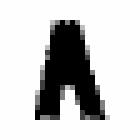

In [14]:
# learn = None
learner = None
gc.collect()

if 'ocr_learner' not in locals() or ocr_learner is None:
    ocr_learner = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                              df=get_combined_az_and_tmnist_df, 
                              load_saved=True)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   folder="results/test_x_resent_loss",
                                   ocr_learner=ocr_learner,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.render_letter("A", scale=5)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


Weight 0.0


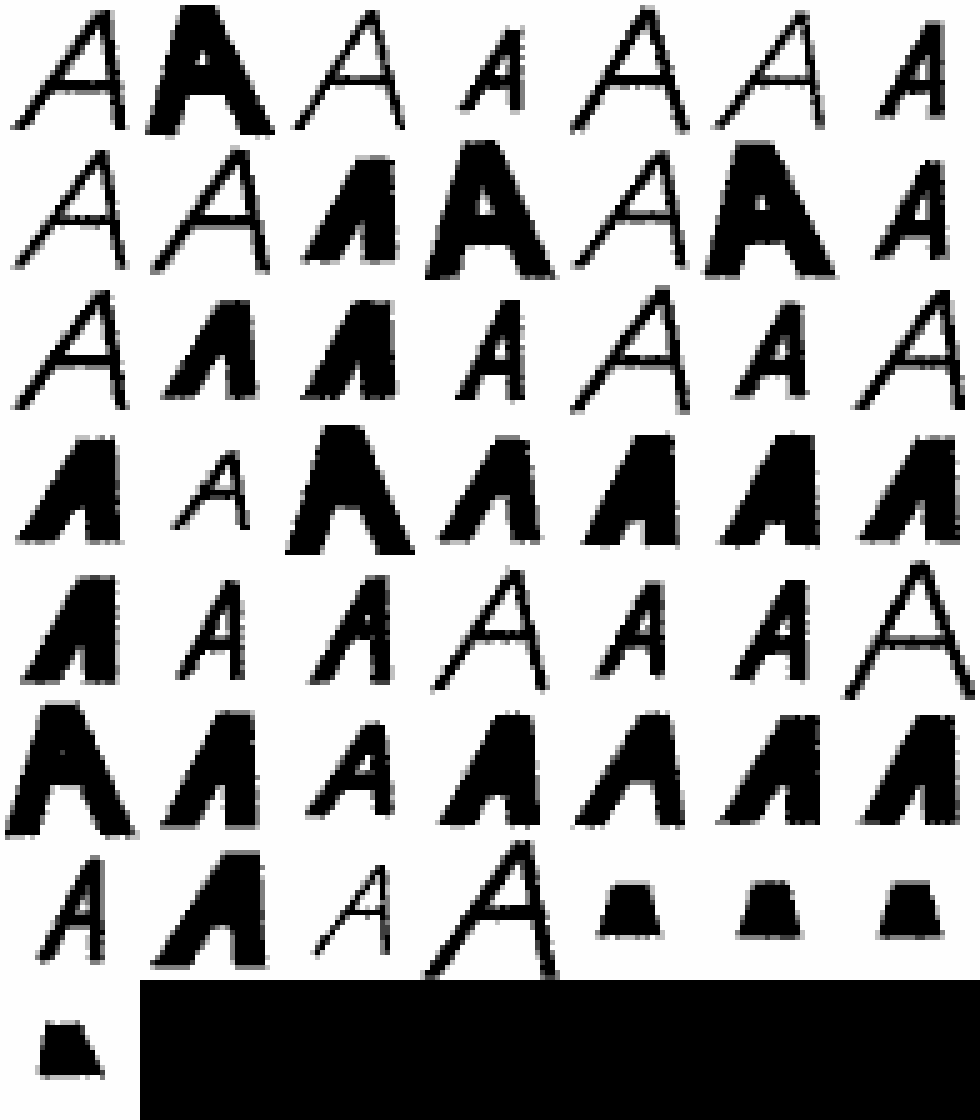

Weight 0.1111111111111111


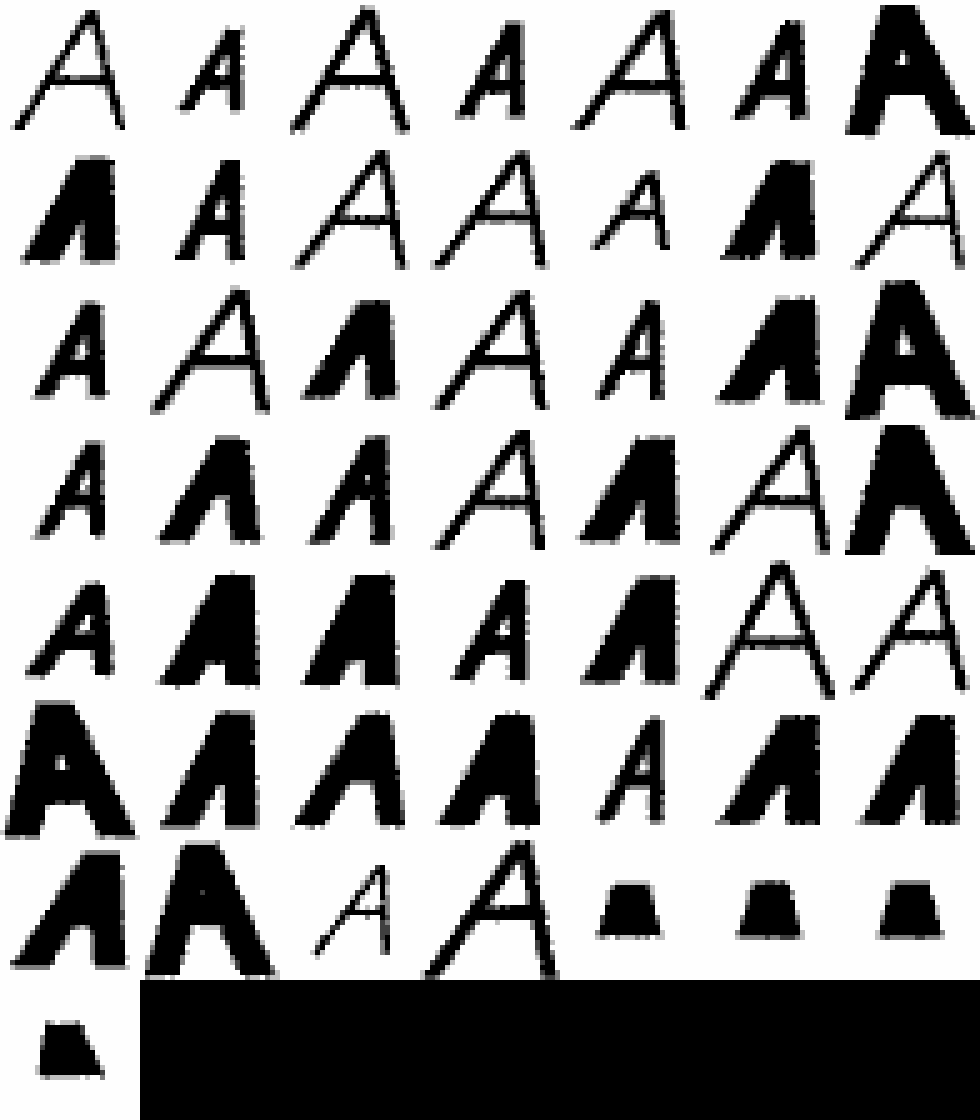

Weight 0.2222222222222222


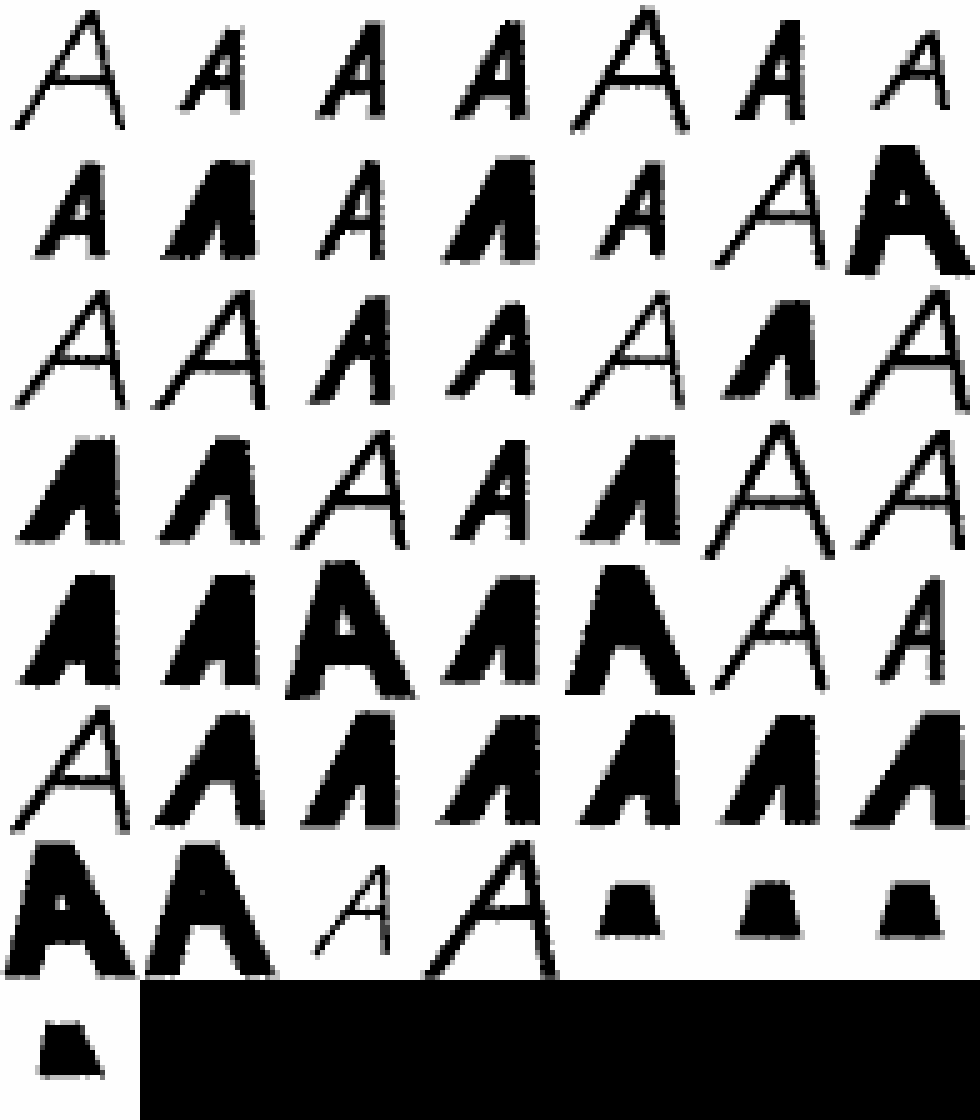

Weight 0.3333333333333333


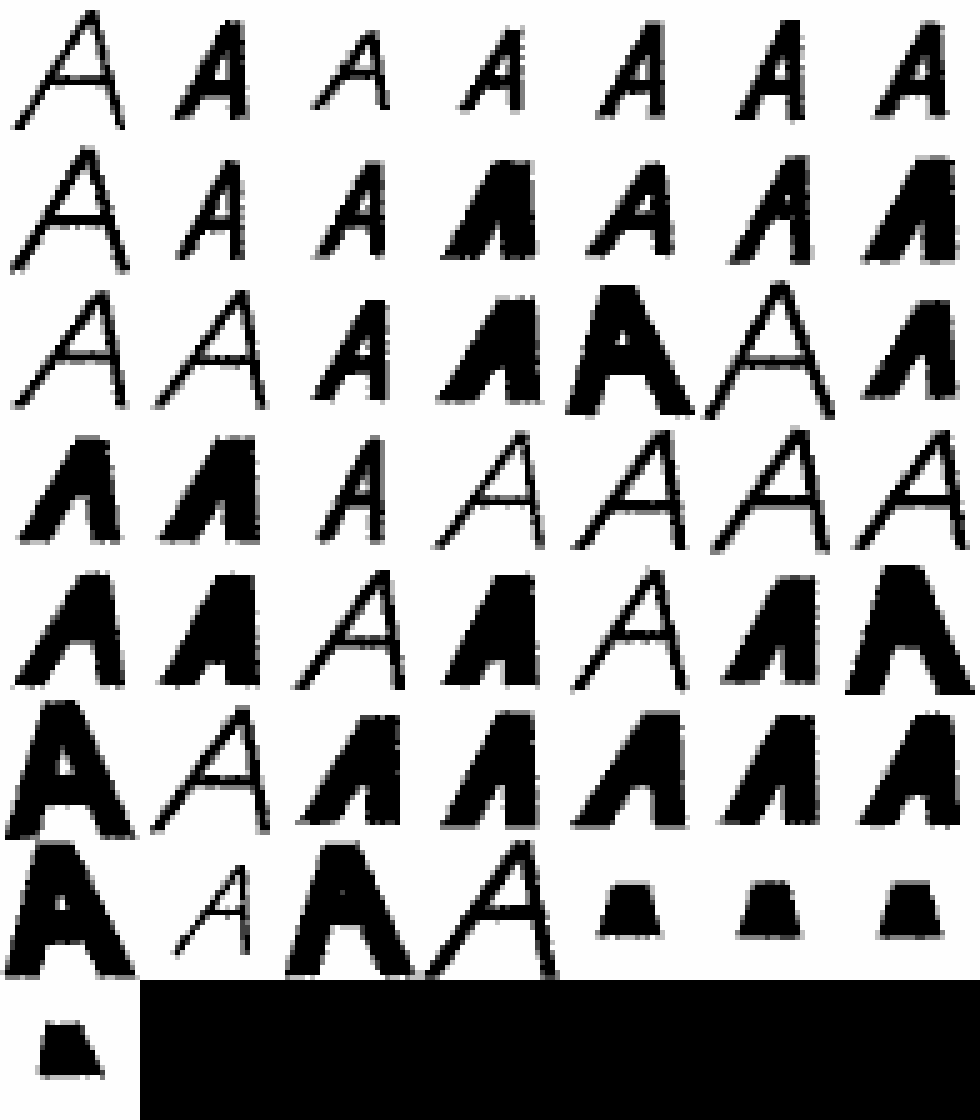

Weight 0.4444444444444444


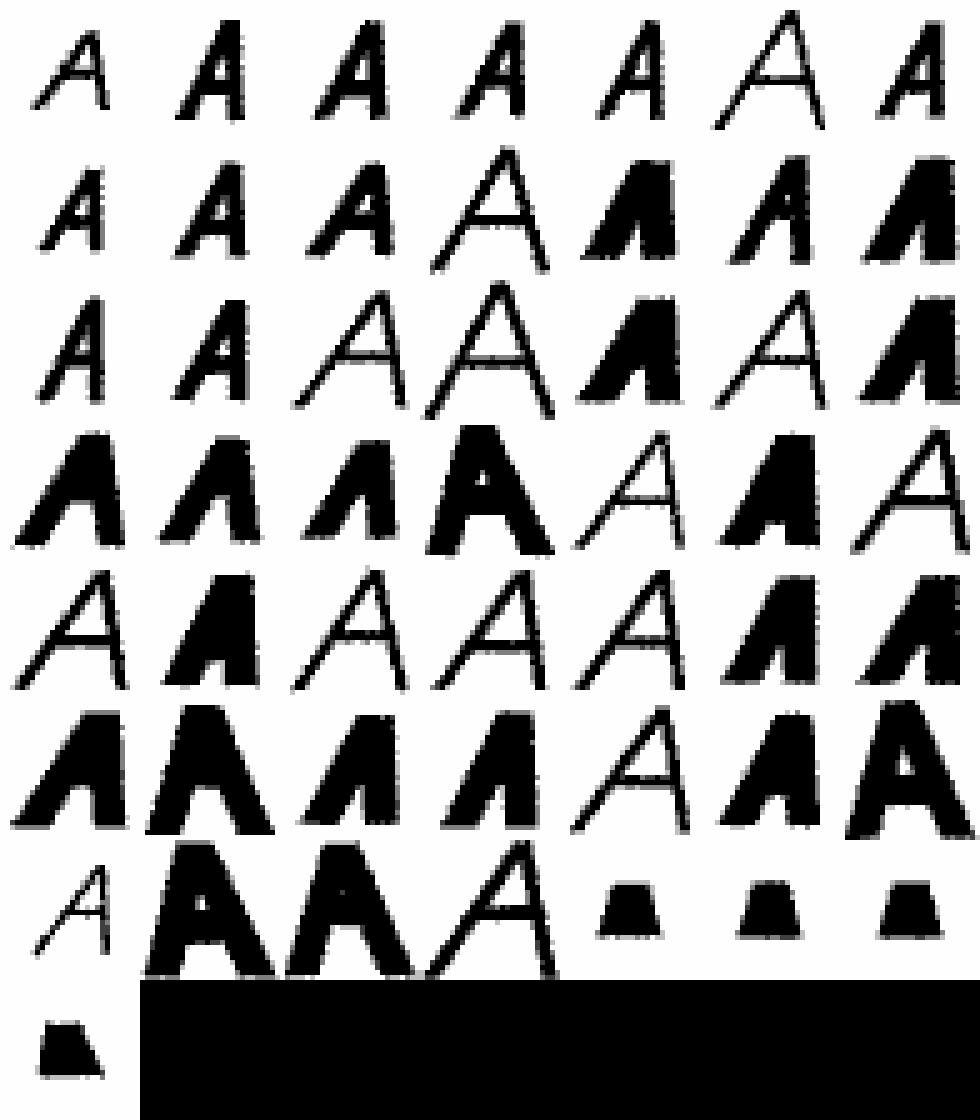

Weight 0.5555555555555556


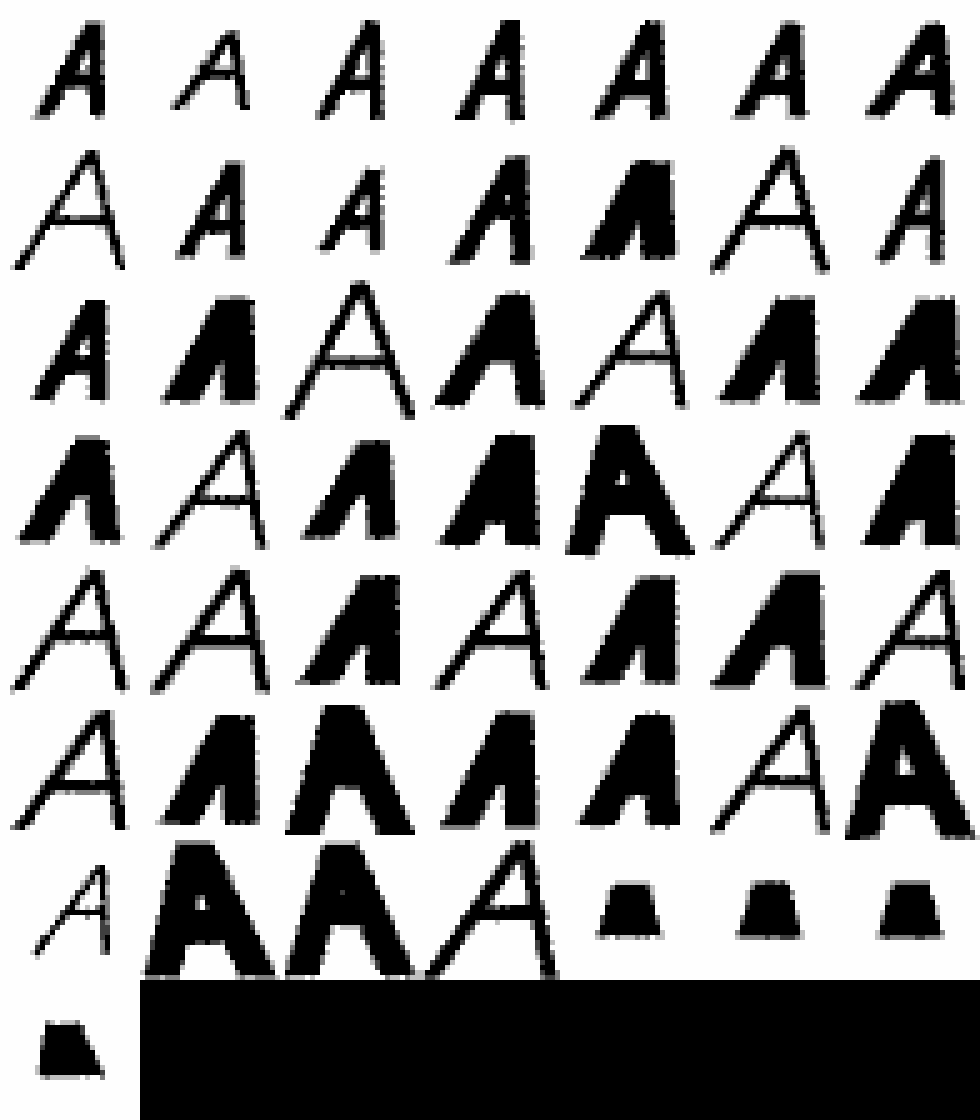

Weight 0.6666666666666666


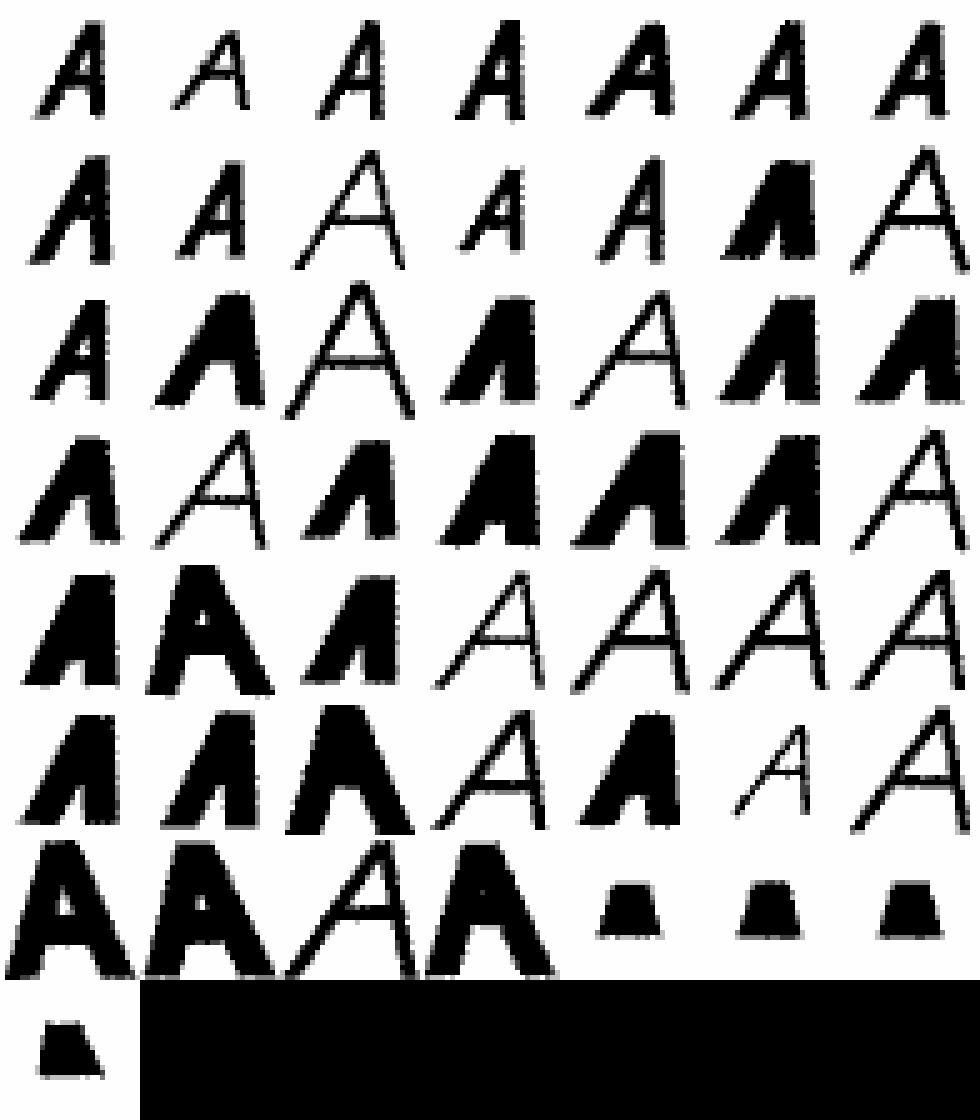

Weight 0.7777777777777778


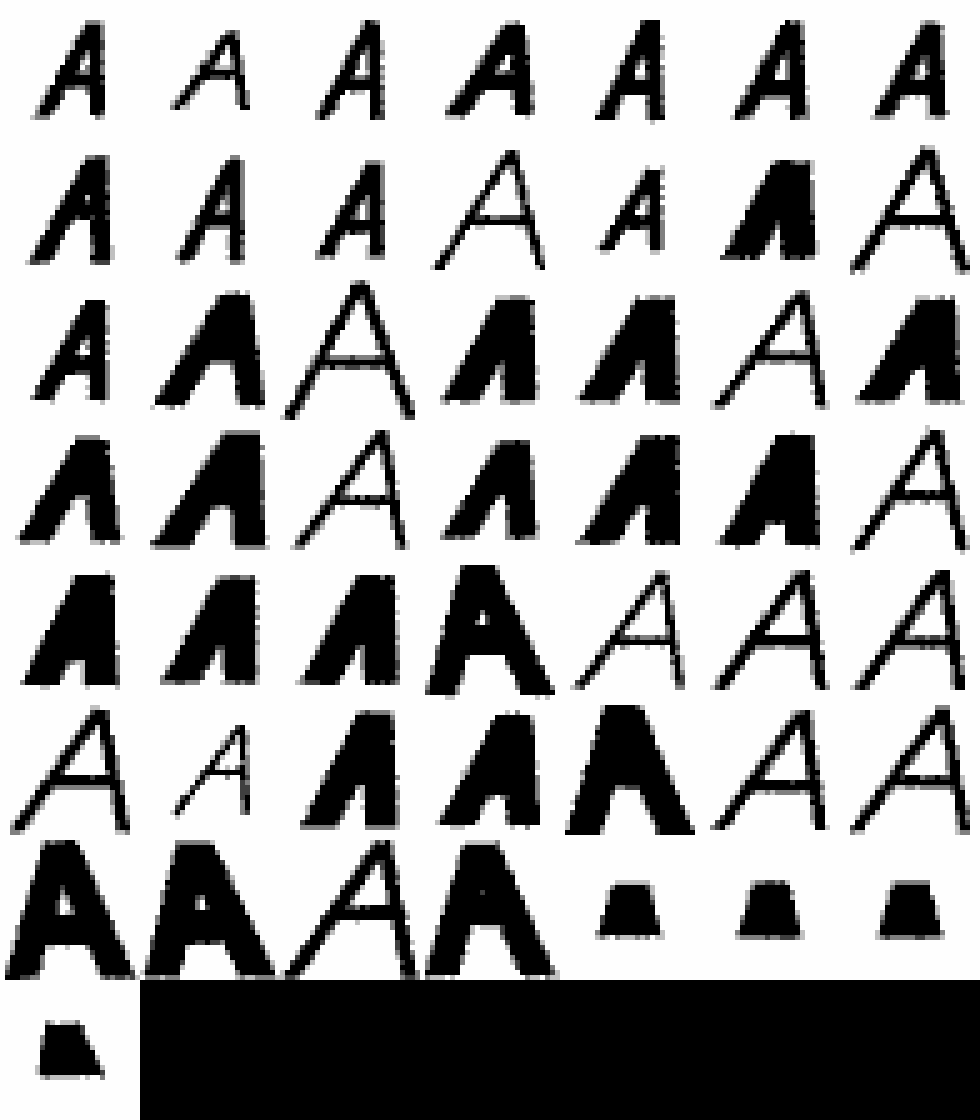

Weight 0.8888888888888888


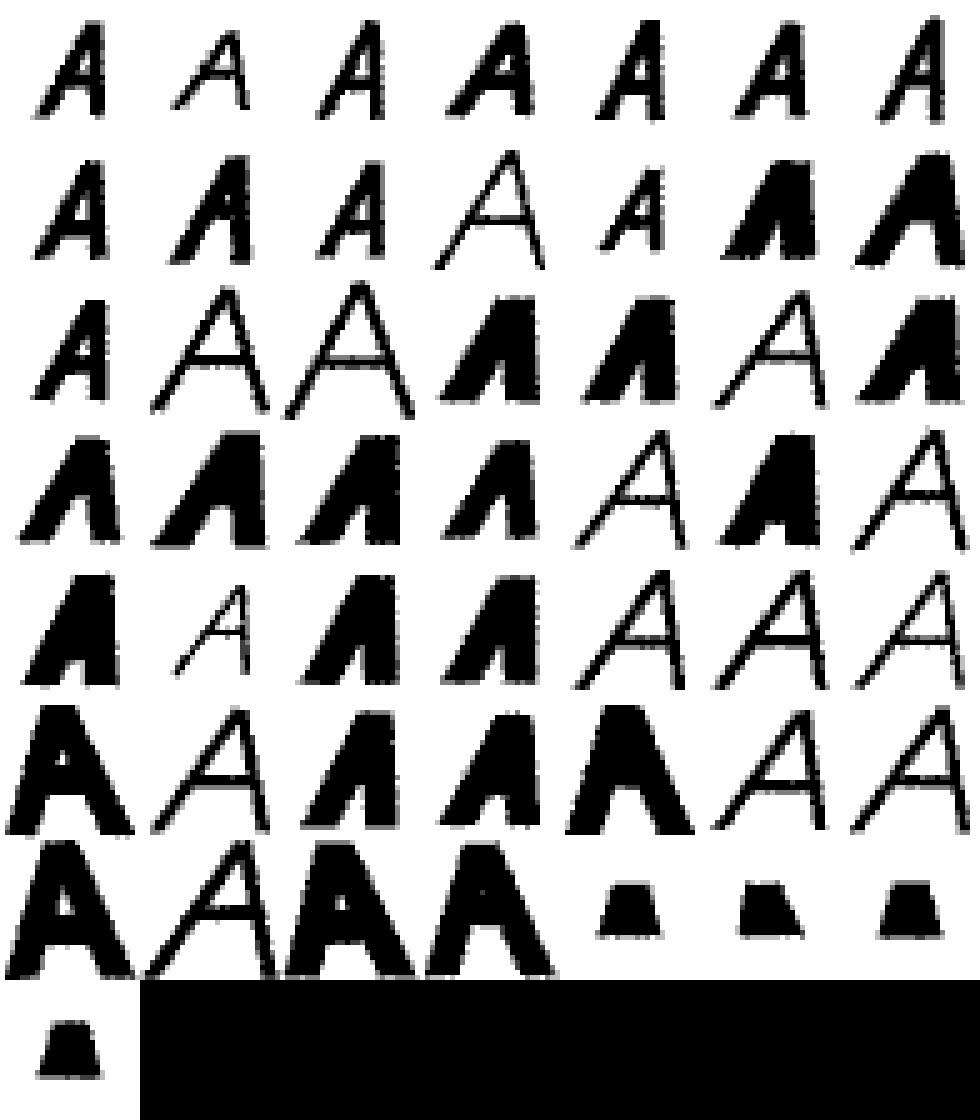

Weight 1.0


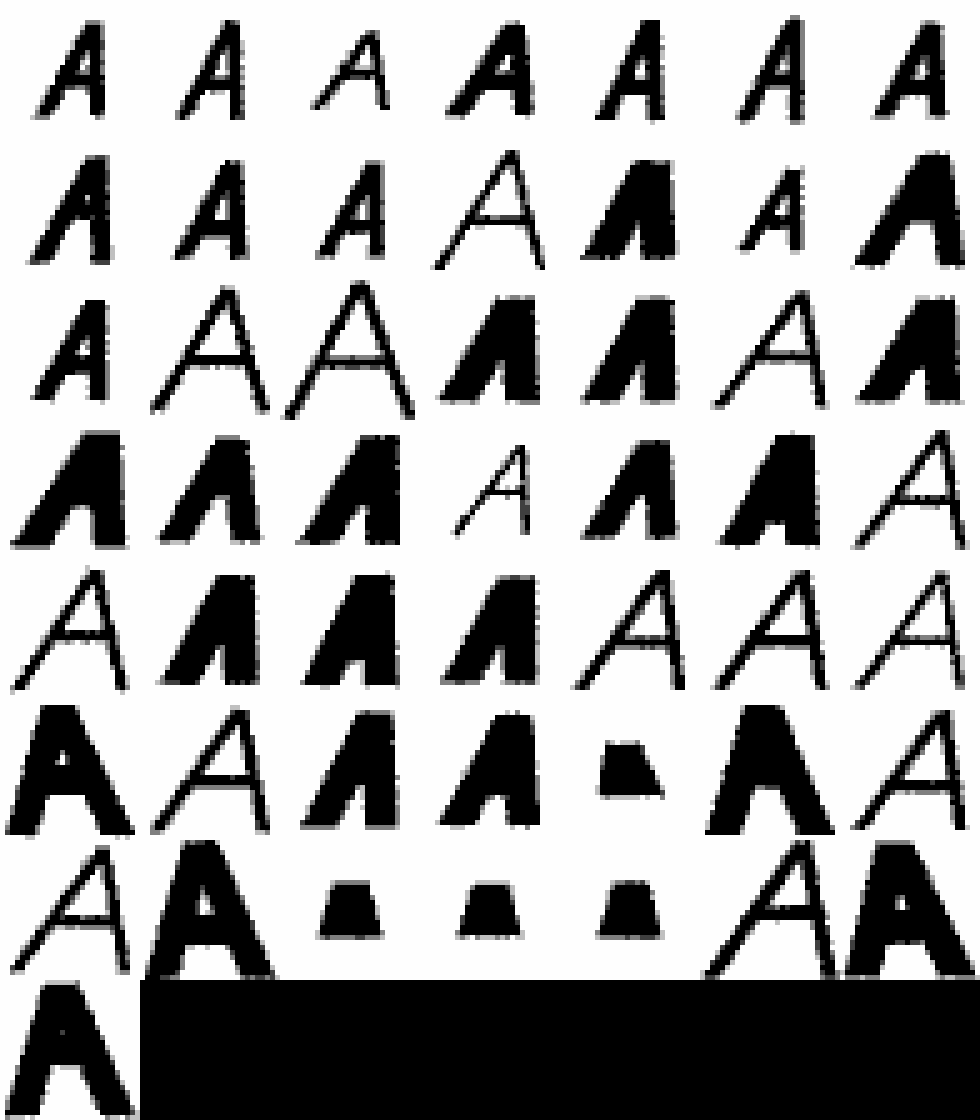

In [309]:
losses_and_activations = get_losses_and_activations(learner, sd_dist=None)
n_weights = 10
img_grids = {}
for i in range(n_weights):
    w = i * 1/(n_weights - 1)
    imgs = [x["img"] for x in sorted(losses_and_activations, key=lambda y: ((1 - w) * y["xe_loss"] + w * y["re_loss"]).item())]
    img_grids[w] = image_grid(imgs)
for w, g in img_grids.items():
    print(f"Weight {w}")
    display(g)

### 5. A closer look at activation spectra

To see if there's another component in addition to pure cross entropy loss we might want to add to the OCR loss, let's study the activation spectra of the different results that have similar loss.

This is how the softmaxed activations excluding the correct category 'A' look like. We can see that there are some differences.

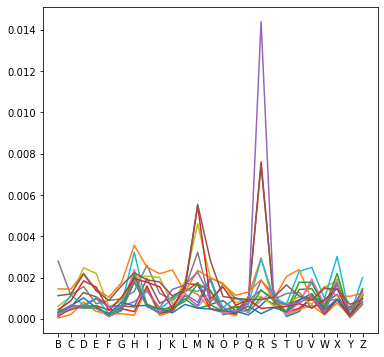

In [18]:
losses_and_activations = get_losses_and_activations(learner)
vocab = VOCAB_UC if 'learner' not in locals() or learner is None else learner.vocab
plot_activations(losses_and_activations, vocab, softmax=True, exclude="A")

If we have a look at the residual entropies, i.e. the entropy within the incorrect predictions, we see that they do not fall along a line when plotted against loss on the x-axis. This means, we might want leverage this as an additional part of OCR loss.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


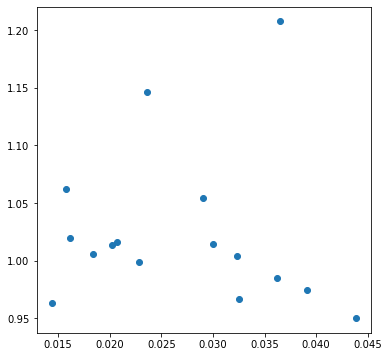

In [21]:
_, entropies = plot_residual_entropy(losses_and_activations)

Finally, let's see what if any visual differences are there in terms of residual entropy. They seem to fall into a somewhat understandable order, which is different from that based on loss. It remains to be seen whether the residual entropy signal is useful and what weight is should be given if one wishes to make it so.

**NB.** we order the images in descending order of residual entropy, as we would prefer the entropy to be as high as possible i.e. the activations as evenly distributed among the incorrrect categories as possible.

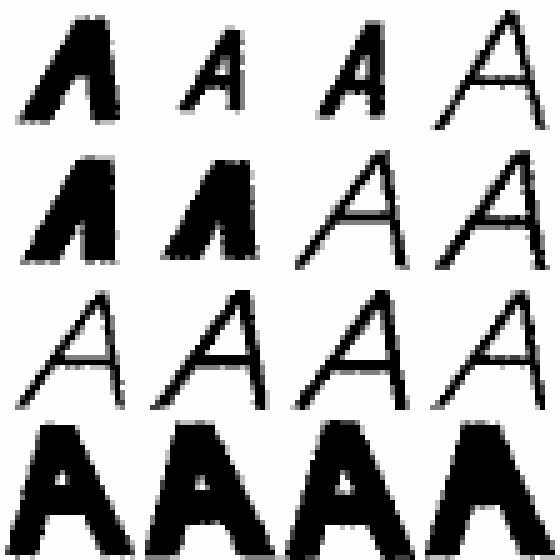

In [247]:
imgs_and_entropies = list(zip(entropies, [x["img"] for x in losses_and_activations]))
imgs_and_entropies.sort(key=lambda x: x[0], reverse=True) # Sort reverse!
image_grid([x[1] for x in imgs_and_entropies])

To double-check, let's plot the activation spectra for the results with the highest and lowest residual entropies. From the plot we can conclude that residual entropy is a suitable metric for the 'spikiness' of the activations.

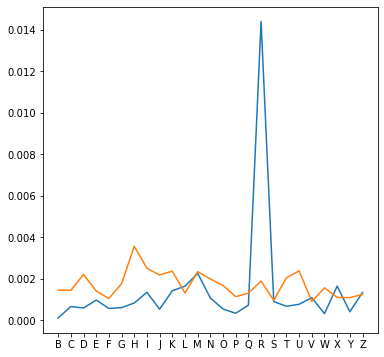

In [31]:
# Note that the entropies are actually reversed, so argmax gets 
# the one with the higher res ent loss i.e. lower entropy
extremes = [
    losses_and_activations[np.argmax(entropies)],
    losses_and_activations[np.argmin(entropies)]
    ]
plot_activations(extremes, vocab, softmax=True, exclude="A")

Finally, let's have a look at how the distribution of the residual activations contributes to the plain cross entropy loss, as it does have an effect on the denominator used by softmax. 

1. Pick the activations for the example with the highest res ent loss, i.e. the most spiky residual activations (blue line on the graph above).
2. Make a copy of that and distribute the residual activations (before softmax) evenly amongst categories, thus yielding an exemplar with maximum residual entropy but with the same sum total of activations.
3. Compare cross entropy and residual entropy losses for these.

From the results we see that the higher residual entropy (and thus lower RE loss) is actually already reflected in the cross entropy loss. Thus, we might not want to use res ent loss after all.

XE loss 0.03648417815566063 • RE loss 1.207586407661438
XE loss 0.02167501114308834 • RE loss 0.9320025444030762


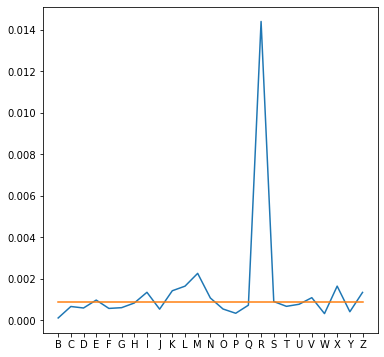

In [64]:
low_entropy = extremes[0]["activations"]
high_entropy = low_entropy.clone()
high_entropy[1:] = torch.full_like(high_entropy[1:], high_entropy[1:].mean())
assert (high_entropy.sum() - low_entropy.sum()).abs() < low_entropy.sum().abs() / 100
loss = torch.nn.CrossEntropyLoss()
target = tensor([0])
plt.figure(figsize=(6,6))
names = [x for x in learner.vocab if x != "A"]
for acts in [low_entropy, high_entropy]:
    print(f"XE loss {loss(acts.unsqueeze(0), target)} • RE loss {residual_entropy(acts, softmax=True)}")
    acts = F.softmax(acts, dim=-1)
    acts = acts.numpy()[1:]
    plt.plot(names, acts)


### 4. Interlude: Check how far SGD (or Adam) optimisation gets us

After the naïve optimisation attempts, let's see how far we could've gotten with differential optimisation.

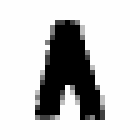

In [174]:
# learn = None
vector_learner = None
gc.collect()

if 'ocr_learner' not in locals() or ocr_learner is None:
    ocr_learner = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                              df=get_combined_az_and_tmnist_df, 
                              load_saved=True)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   folder="results/test_7_letter_A_Adam",
                                   ocr_learner=ocr_learner,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.render_letter("A", scale=5)

First, let's just try to optimise all parameters at once.

epoch,train_loss,valid_loss,time
0,2.463664,2.461631,00:00
1,2.468741,2.466581,00:00
2,2.463943,2.438395,00:00
3,2.453895,2.418550,00:00
4,2.445214,2.410484,00:00
5,2.437356,2.413414,00:00
6,2.432550,2.412402,00:00
7,2.427456,2.410439,00:00
8,2.423170,2.395369,00:00
9,2.418095,2.403845,00:00


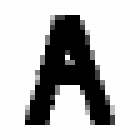

In [8]:
lr = 1e-2
learner.fit(10, lr=lr)
learner.render_letter("A", scale=5)

epoch,train_loss,valid_loss,time
0,2.376004,2.383774,00:00
1,2.377672,2.383474,00:00
2,2.377006,2.380571,00:00
3,2.376041,2.377157,00:00
4,2.376128,2.376878,00:00
5,2.376869,2.372841,00:00
6,2.376175,2.382202,00:00
7,2.376496,2.373649,00:00
8,2.375835,2.380657,00:00
9,2.375703,2.376138,00:00


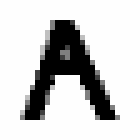

In [16]:
lr = 2e-3
learner.fit(20, lr=lr)
learner.render_letter("A", scale=5)

After quite a few epochs of training with decreasin learning rates (from `1e-2` to `2e-3`), we actually get quite satisfactory results, but we still can't get to the lowest loss ranges that we reach with naïve optimisation.

Let's now try to try and optimise parameters individually.

It seems that there's no difference between this approach and the regular one, which ought to be expected. The end result did not change with any learning rate except for the worse.

In [21]:
param_values = {(n, learner.get_param_value(n).item()) for n in learner.model.param_names}
param_names = list(learner.model.param_names)
param_values

{('Crossbar y offset, A', -0.07114353775978088),
 ('Height', 0.7137360572814941),
 ('Midline', 0.3865865468978882),
 ('Offset xp from symmetry, AXZ', -0.0487978458404541),
 ('Overshoot, AMNVW', 0.0),
 ('Slant', 0.39271318912506104),
 ('Stroke width', 0.13070808351039886),
 ('Width, AV', 0.9435300827026367)}

epoch,train_loss,valid_loss,time
0,2.381314,2.391845,00:00
1,2.382238,2.383425,00:00
2,2.383502,2.385332,00:00
3,2.384564,2.386120,00:00
4,2.384139,2.382108,00:00
5,2.383222,2.386717,00:00
6,2.383076,2.382982,00:00
7,2.384247,2.390471,00:00
8,2.385145,2.385516,00:00
9,2.385725,2.383454,00:00


epoch,train_loss,valid_loss,time
0,2.390374,2.380502,00:00
1,2.385071,2.380941,00:00
2,2.384235,2.381237,00:00
3,2.382351,2.381088,00:00
4,2.382360,2.380705,00:00
5,2.381186,2.382936,00:00
6,2.380343,2.376106,00:00
7,2.379802,2.383579,00:00
8,2.379697,2.383621,00:00
9,2.379559,2.378728,00:00


epoch,train_loss,valid_loss,time
0,2.377118,2.380440,00:00
1,2.380528,2.381865,00:00
2,2.379668,2.381591,00:00
3,2.378727,2.378766,00:00
4,2.378880,2.384259,00:00
5,2.377373,2.380421,00:00
6,2.377105,2.386579,00:00
7,2.377050,2.373338,00:00
8,2.377378,2.378048,00:00
9,2.377133,2.384864,00:00


epoch,train_loss,valid_loss,time
0,2.378547,2.380706,00:00
1,2.376963,2.382044,00:00
2,2.376028,2.382329,00:00
3,2.378005,2.382477,00:00
4,2.379100,2.377726,00:00
5,2.380917,2.384803,00:00
6,2.380884,2.380169,00:00
7,2.379703,2.388327,00:00
8,2.380450,2.382517,00:00
9,2.381212,2.384925,00:00


epoch,train_loss,valid_loss,time
0,2.383945,2.380353,00:00
1,2.380788,2.377140,00:00
2,2.380159,2.381429,00:00
3,2.379488,2.378953,00:00
4,2.380353,2.384616,00:00
5,2.381137,2.381690,00:00
6,2.381920,2.382021,00:00
7,2.381559,2.379822,00:00
8,2.380182,2.384570,00:00
9,2.380640,2.374418,00:00


epoch,train_loss,valid_loss,time
0,2.377536,2.378489,00:00
1,2.377166,2.379116,00:00
2,2.376177,2.379590,00:00
3,2.376886,2.381219,00:00
4,2.376751,2.377469,00:00
5,2.376412,2.380960,00:00
6,2.377208,2.380317,00:00
7,2.378183,2.378951,00:00
8,2.378663,2.378999,00:00
9,2.378427,2.377358,00:00


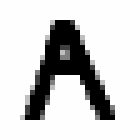

In [31]:
exclude = ["Height", "Slant"] # Let's keep height constant
lr = 1e-2
epochs = 10
random.shuffle(param_names)
for p in param_names:
    if p in exclude: continue
    learner.freeze_params()
    learner.unfreeze_params([p])
    learner.fit(epochs, lr=lr)
learner.render_letter("A", scale=5)

As a final test on SGD, let's see what results we get with different initial conditions.

In [36]:
iters = 20
epochs = [10, 20, 20]
lrs = [1e-2, 5e-3, 1e-3]

def noop(*args): pass
logger = learner.recorder.logger
learner.recorder.logger = noop
learner.unfreeze_params()
results = []
for i in range(iters):
    print(f"Starting iter {i + 1}/{iters}")
    learner.reset_parameters()
    for e_n, e_lr in zip(epochs, lrs):
        learner.fit(e_n, e_lr)
    p_vals = {(n, learner.get_param_value(n).item()) for n in learner.model.param_names}
    results.append({
        "param_values": p_vals,
        "loss_at_end": learner.recorder.losses[-1].item(),
        "img": learner.render_letter("A", scale=5)
        })
learner.recorder.logger = logger

Starting iter 1/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 2/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 3/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 4/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 5/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 6/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 7/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 8/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 9/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 10/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 11/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 12/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 13/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 14/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 15/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 16/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 17/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 18/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 19/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Starting iter 20/20


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


Looking at the results we see that there is some convergence. The results might've been different if the training times were longer.

Loss min 2.340656042098999 •  max 3.3073525428771973 • sd 0.2792788635087357


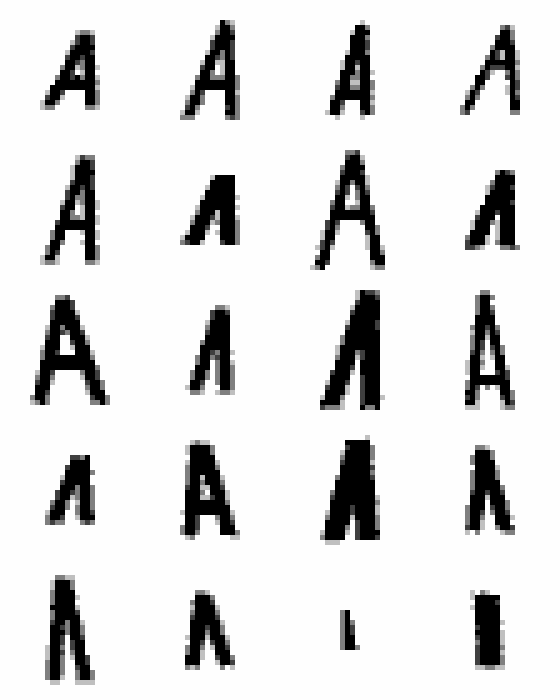

In [40]:
results.sort(key=lambda x: x["loss_at_end"])
losses = [x["loss_at_end"] for x in results]
imgs = [x["img"] for x in results]
print(f"Loss min {min(losses)} •  max {max(losses)} • sd {statistics.stdev(losses)}")
image_grid(imgs)

The best exemplars actually have very low losses. Let's compare those with the ones we produced with naïve optimisation.

In [48]:
naive_results = pickle.load(open("results/test_6_letter_A_all_params/all_res_2.pkl", "rb"))
naive_losses = [x[-1]["loss_at_end"] for x in naive_results]
loss_stats = DataFrame(
    [[min(x), max(x), statistics.stdev(x)] for x in [losses, naive_losses]],
    columns=["Min loss", "Max loss", "Loss SD"],
    index=["SGD", "Naïve"]
    )
loss_stats

,Min loss,Max loss,Loss SD
SGD,2.340656,3.307353,0.279279
Naïve,2.340788,2.989603,0.168784


### 3. The letter A, repeated optimisation of single parameters

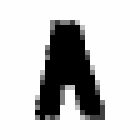

In [55]:
# learn = None
vector_learner = None
gc.collect()

if 'ocr_learner' not in locals() or ocr_learner is None:
    ocr_learner = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                              df=get_combined_az_and_tmnist_df, 
                              load_saved=True)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   folder="results/test_6_letter_A_all_params",
                                   ocr_learner=ocr_learner,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.render_letter("A", scale=5)

Above, we see the starting letter created with the same seed as in the previous tests. Now, let's do a few iterations over the parameters and optimise the one by one.

Epoch 0 • Loss 2.346042046180138 (values applied immediately)


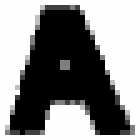

Epoch 1 • Loss 2.3435455285585842 (values applied immediately)


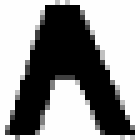

Epoch 2 • Loss 2.346761263333834 (values applied immediately)


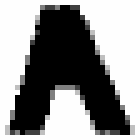

Epoch 3 • Loss 2.3448876234201284 (values applied immediately)


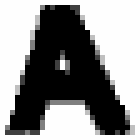

Epoch 4 • Loss 2.3490453316615176 (values applied immediately)


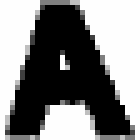

In [71]:
res = fit_pvals_naively(learner, epochs=5)
for e in res:
    print(e["info"])
    display(e["img"])

Let's now check what effect the initial conditions i.e. param values play by creating a few iterations of the process.

Iteration 0 • Loss 2.3678323305570164


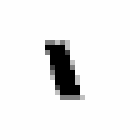

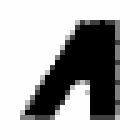

Iteration 1 • Loss 2.354859077013456


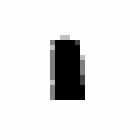

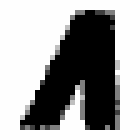

Iteration 2 • Loss 2.9925346557910624


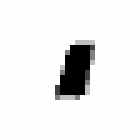

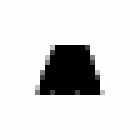

Iteration 3 • Loss 2.3455508122077355


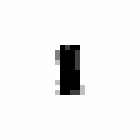

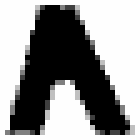

Iteration 4 • Loss 2.3507348207327037


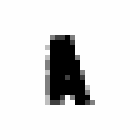

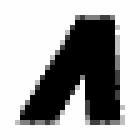

Iteration 5 • Loss 2.3629362399761495


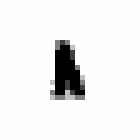

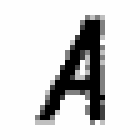

Iteration 6 • Loss 2.3461852073669434


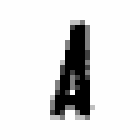

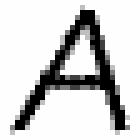

Iteration 7 • Loss 2.3491265223576474


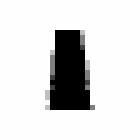

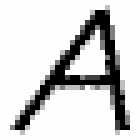

Iteration 8 • Loss 2.348211490190946


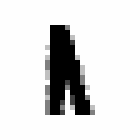

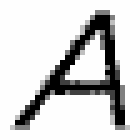

Iteration 9 • Loss 2.3474069925454946


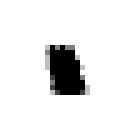

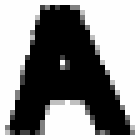

In [72]:
all_res = reset_params_and_optimise(learner)

The results are very interesting displaying a couple of minima they epochs seem to converge on. The results are however not entirely intuitive. Let's plot the final values for the params and see what do they look like.

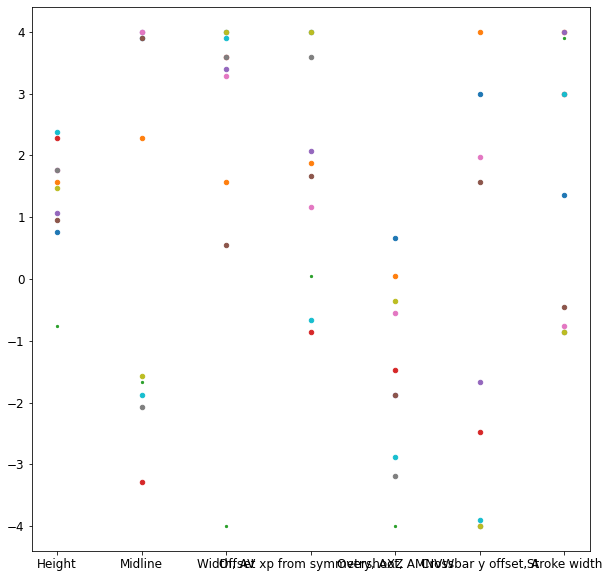

In [110]:
plot_param_values(learner, all_res)

The results are a bit unsubstantive. Let's try once more with a lot more iterations.

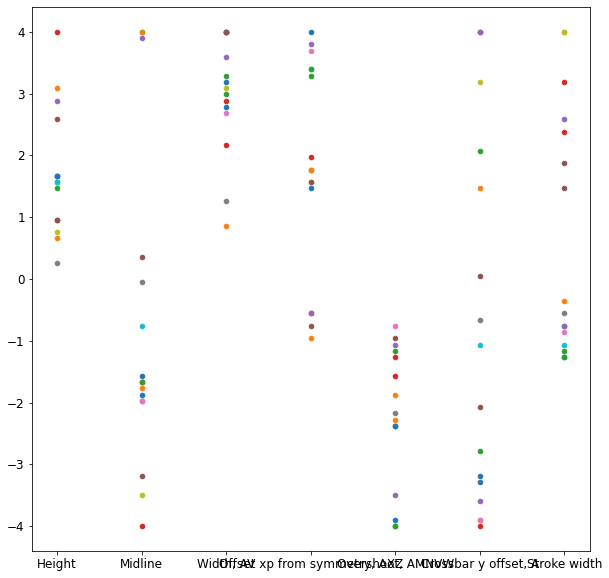

In [164]:
# all_res_2, init_imgs_2 = reset_params_and_optimise(learner, n_iters=50, vocal=False)
# import pickle
# pickle.dump(all_res_2, open(os.path.join(learner.image_saver.folder, "all_res_2.pkl"), "wb"))
plot_param_values(learner, filter_results(all_res_2, sd_dist=.05), vary_marker_size=False)

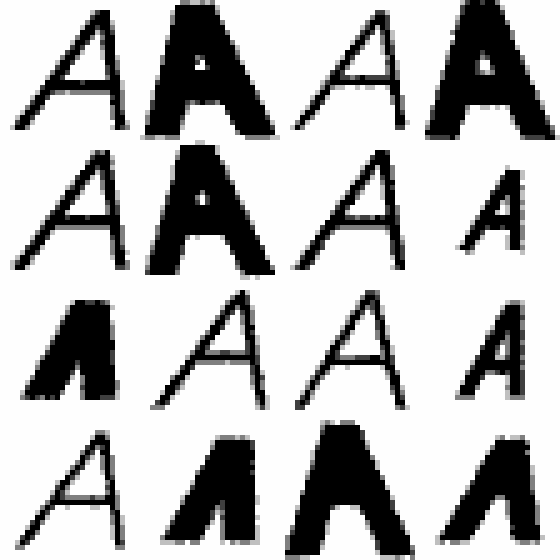

In [148]:
image_grid(filter_imgs(all_res_2, sd_dist=.05))

In [ ]:
# vector_learner.set_param(param, optimal_pval)
# lr = 1e-3
# with no_debug(vector_learner): vector_learner.fit(10, lr=lr)
# current_pval = vector_learner.model.get_param(param).item()
# current_loss = vector_learner.recorder.losses[-1].item()
# loss_d = current_loss - min_loss
# print(f"Loss {'WORSE ' if loss_d > 0. else 'better'}   by {loss_d}")
# print(f"Param changed by {current_pval - optimal_pval} ({param})")
# vector_learner.render_letter("A", scale=5)

### 2. The letter A, optimising all params one-by-one

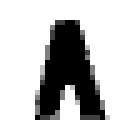

In [29]:
# learn = None
vector_learner = None
gc.collect()

if 'ocr_learner' not in locals() or ocr_learner is None:
    ocr_learner = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                              df=get_combined_az_and_tmnist_df, 
                              load_saved=True)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   folder="results/test_6_letter_A_all_params",
                                   ocr_learner=ocr_learner,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.render_letter("A", scale=5)

Optimising param Height
Optimising param Slant
Optimising param Midline
Optimising param Width, AV
Optimising param Offset xp from symmetry, AXZ
Optimising param Overshoot, AMNVW
Optimising param Crossbar y offset, A
Optimising param Stroke width


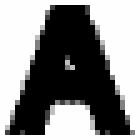

In [30]:
p_losses = {}
opt_pvals = {}
for p in learner.params:
    name = learner.model.get_param_name(p)
    print(f"Optimising param {name}")
    df = learner.calculate_losses(p, plot=False)
    opt_pval = get_argmin(df)
    # min_loss = df.loss.min()
    p_losses[name] = df
    opt_pvals[name] = opt_pval
    learner.set_param(p, opt_pval)

learner.render_letter("A", scale=5)

Above, a `smooth_loss_dist` of 3 is applied by default. As we can see from the graphs below, the curves look nicer. Let's also calculate the mean difference between smoothed and original losses. As we've noted earlier in the case with the unimplemented Slant parameter, there seems to be a random fluctuation in the loss of magnitude 0.04.

Median abs difference between smoothed and original losses is 0.007137843540736766


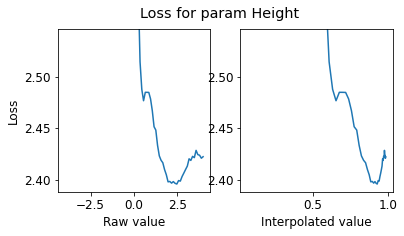

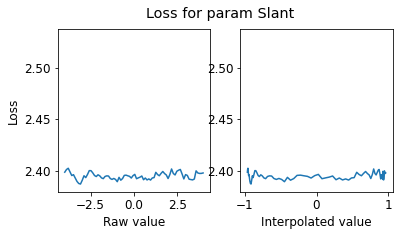

In [43]:
def print_median_loss_delta(p_losses, vocal = True):
    import statistics
    loss_deltas = []
    for df in p_losses.values():
        ld = abs(df.loss - df.raw_loss)
        loss_deltas.append(ld)
    ld_median = statistics.median(flatten_list(loss_deltas))
    if vocal: print(f"Median abs difference between smoothed and original losses is {ld_median}")
    return ld_median

print_median_loss_delta(p_losses)

for i, (p, df) in enumerate(p_losses.items()):
    if i == 2: break
    plot_param_losses(df, p, zoom_range=.15, plot_width=3)

The delta is still a bit small compared to the fluctuation. And we can see from the graph for Slant, above, that the line is not smooth. Let's try to manually try smoothing with different distances.

Smooth distance 2 • Loss delta 0.007128930091857777
Smooth distance 3 • Loss delta 0.007137843540736766
Smooth distance 4 • Loss delta 0.007713887426588295
Smooth distance 5 • Loss delta 0.00826318697495898
Smooth distance 6 • Loss delta 0.00904045655177188
Smooth distance 7 • Loss delta 0.00938230355580627
Smooth distance 8 • Loss delta 0.009855067028718745
Smooth distance 9 • Loss delta 0.010477555425543406


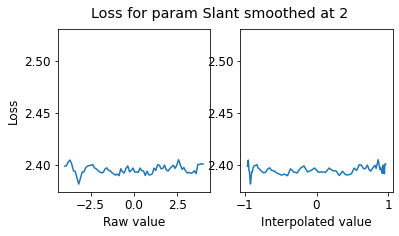

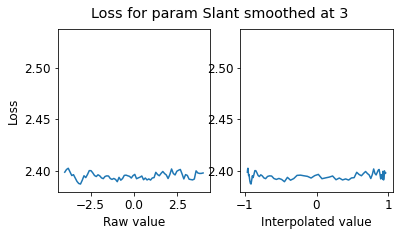

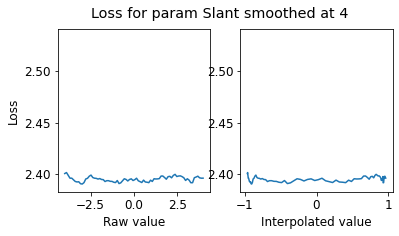

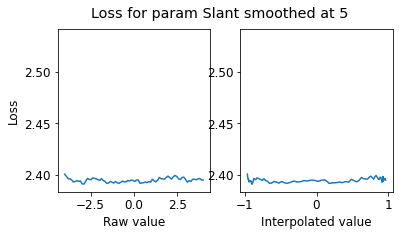

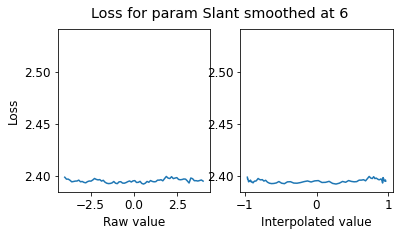

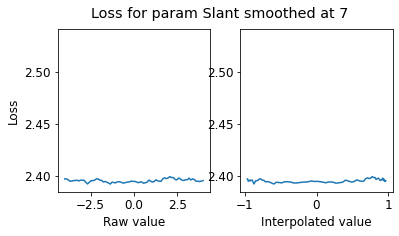

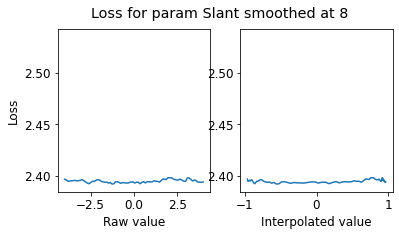

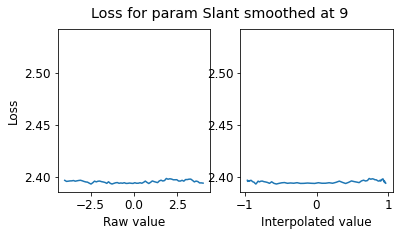

In [47]:
def smooth_losses(p_losses, dist=3):
    for df in p_losses.values(): df.loss = smooth(df.raw_loss, dist=dist)

for dist in range(2, 10):
    smooth_losses(p_losses, dist)
    ld_median = print_median_loss_delta(p_losses, vocal=False)
    print(f"Smooth distance {dist} • Loss delta {ld_median}")
    plot_param_losses(p_losses["Slant"], f"Slant smoothed at {dist}", zoom_range=.15, plot_width=3)

From the graphs above, it seems picking a smoothing distance of 5 or 6 (with the default of 80 steps in total) might be good.

### 1. The letter A, optimising Height

SansSerifFontRL with params:
  0 Height: -0.5 (0.40866366028785706)
  1 Slant: 1.6600158214569092 (0.6804802417755127) <FROZEN>
  2 Midline: -0.46854496002197266 (0.38496071100234985) <FROZEN>
  3 Width, AV: 1.5 (0.8266957402229309) <FROZEN>
  4 Offset xp from symmetry, AXZ: 1.2000000476837158 (0.13426241278648376) <FROZEN>
  5 Overshoot, AMNVW: -0.10000000149011612 (0.0) <FROZEN>
  6 Crossbar y offset, A: -0.9737100601196289 (-0.2258583903312683) <FROZEN>
  7 Stroke width: -0.6000000238418579 (0.09504248946905136) <FROZEN>


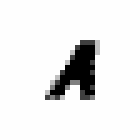

In [365]:
# learn = None
vector_learner = None
gc.collect()

if 'learn' not in locals() or learn is None:
    learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, 
                              df=get_combined_az_and_tmnist_df, 
                              load_saved=True)

cb = DebugCB(vocal=False)
vector_learner, _ = create_vector_learner(cbs=cb,
                                        folder="results/test_5_whole_font",
                                        ocr_learner=learn,
                                        n_colors_out=1,
                                        normalise=False,
                                        lr=1e-2, 
                                        debug=False,
                                        seed=42)

vector_learner.set_param("Height", -.5)
vector_learner.set_param("Width, AV", 1.5)
vector_learner.set_param("Stroke width", -.6)
vector_learner.set_param("Offset xp from symmetry, AXZ", 1.2)
vector_learner.set_param("Overshoot, AMNVW", -0.1)
vector_learner.freeze_params()
vector_learner.unfreeze_params(["Height"])
print(vector_learner.model)
vector_learner.render_letter("A", scale=5)

,value,interpolated_value,loss,pred,pred_correct,pred_activation
19,-0.102564,0.500662,2.345713,A,True,0.974850
21,0.307692,0.597506,2.348127,A,True,0.972283
20,0.102564,0.549338,2.356201,A,True,0.963703
22,0.512821,0.644194,2.363250,A,True,0.956218
34,2.974359,0.953832,2.367622,A,True,0.951580


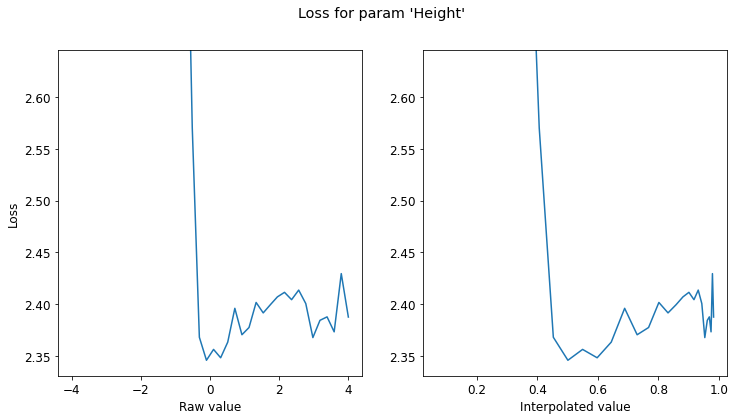

In [371]:
param = "Height"
df = vector_learner.calculate_losses(param, plot=True)
optimal_pval = get_argmin(df)
min_loss = df.loss.min()
df.sort_values(by="loss").head()

epoch,train_loss,valid_loss,time
0,2.348516,2.347574,00:00
1,2.347515,2.346330,00:00
2,2.348980,2.350932,00:00
3,2.348657,2.352312,00:00
4,2.348347,2.348695,00:00
5,2.348819,2.348840,00:00
6,2.348960,2.351119,00:00
7,2.349397,2.350796,00:00
8,2.349197,2.347550,00:00
9,2.348869,2.346332,00:00


Loss WORSE    by 0.003155946731567383
Param changed by 0.02899379149461412 (Height)


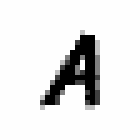

In [382]:

vector_learner.set_param(param, optimal_pval)
lr = 1e-3
with no_debug(vector_learner): vector_learner.fit(10, lr=lr)
current_pval = vector_learner.model.get_param(param).item()
current_loss = vector_learner.recorder.losses[-1].item()
loss_d = current_loss - min_loss
print(f"Loss {'WORSE ' if loss_d > 0. else 'better'}   by {loss_d}")
print(f"Param changed by {current_pval - optimal_pval} ({param})")
vector_learner.render_letter("A", scale=5)

## Export

In [5]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
